In [1]:
using FEM, Potential, AlphaBeta, PyPlot, Printf, PhotonOperator, JLD, LinearAlgebra, Diffusity

┌ Info: Precompiling AlphaBeta [d77d55e1-23be-40c5-8652-b23c35d89ba5]
└ @ Base loading.jl:1278
┌ Info: Precompiling Diffusity [fca15081-c8d4-4aca-bcfd-1103cbe75c6b]
└ @ Base loading.jl:1278


### Part 1: Get collocation points and integration kernel for whole domain

In [2]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration
Nv = 72    # Number of eigenvectors

# Define Physical Domain
xratio = 64. # unit: angstrom
xavg = 0.   # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $V(x)$ and $p_{\rm eq}(x)$

In [3]:
sigma_kref = 8.
kref = get_k_by_sigma(sigma_kref)
Vref = harmonic_well_k_mean(xref, kref, xavg)
rho_eq = get_rhoeq(Vref, w0)
p_eq = rho_eq .* rho_eq;

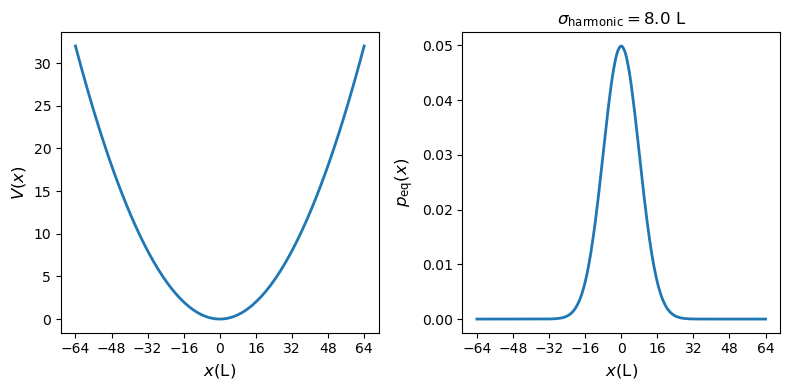

In [221]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8,4))

ax = axes[1]
ax.plot(xref, Vref, linewidth=2)
ax.set_xlabel("\$x\$(L)", fontsize=12)
ax.set_ylabel("\$V(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)
#ax.set_ylim(0, 10)

ax = axes[2]
ax.plot(xref, p_eq, linewidth=2)
ax.set_xlabel("\$x\$(L)", fontsize=12)
ax.set_ylabel("\$p_{\\rm eq}(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)
ax.set_title(@sprintf "\$\\sigma_{\\rm harmonic} = %.1f\$ L" sigma_kref)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/0/harmonic_well_r.svg")
plt.show()

### Part 3: Set parameters about simulations

In [4]:
# physical parameters
save_freq = 1e-2 # unit: s, Save trajectory per 1e-2 s
total_times = 100 # unit: s, totol simulate 100 s
dt = 2e-5 # unit: s  # Integration Times 1ps
D = 500; # Diffusion coefficient, unit: s-1
tau = Int(round(total_times / save_freq, digits=0))  # Number of photons
n_interval = Int(round(save_freq / dt, digits=0));

time_info = @sprintf "Save trajectory per %d timesteps. There will be %d data points." n_interval tau
println(time_info)

Save trajectory per 500 timesteps. There will be 10000 data points.


In [5]:
# Read simulated trajectory from jld file
f_in = "/home/yizaochen/codes/julia/md_pisl/trajectory/harmonic_well_r_0.jld"
y_record = load(f_in, "y_record")
t_record = load(f_in, "t_record")
xref = load(f_in, "xref")
rho_eq = load(f_in, "rho_eq")
k_ref = load(f_in, "k_ref")
D = load(f_in, "D");

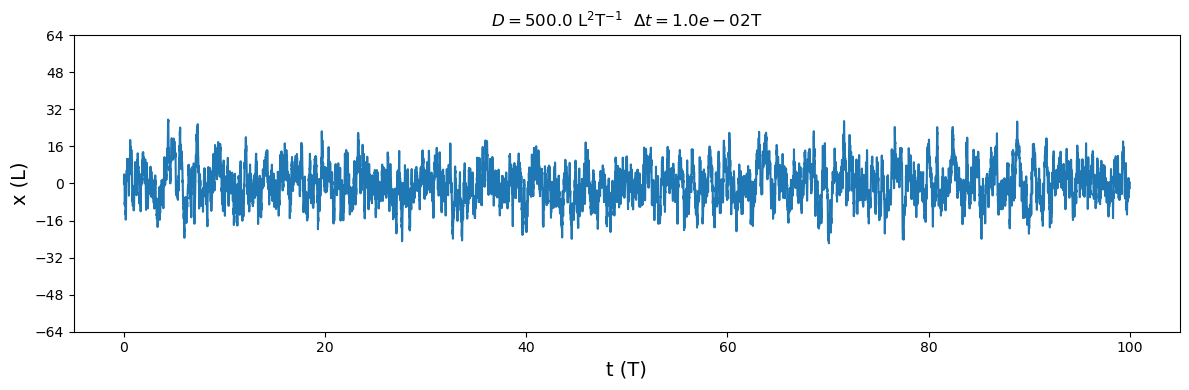

In [16]:
lbfz = 14
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,4))

ax.plot(t_record, y_record)
ax.set_ylabel("x (L)", fontsize=lbfz)
ax.set_xlabel("t (T)", fontsize=lbfz)
ax.set_title(@sprintf "\$ D=%.1f\$ L\$^{2}\$T\$^{-1}\$  \$\\Delta t=%.1e\$T " D save_freq)
ax.set_yticks(-64:16:64)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/0/reduced_traj.svg")
plt.show()

### Part 4: FEM to get eigenvector and eigenvalues when $D=1$

In [6]:
D_unity = 1e0
eigenvalues_prime, eigenvect_mat_prime, rho_eq_by_fem_prime = fem_solve_eigen_by_pref(Nh, Np, xratio, xavg, p_eq, D_unity, Nv)
weight_Qx_prime = get_weight_Qx(N, Nv, w0, eigenvect_mat_prime);

### Part 5: Set Photon $\sigma$

In [7]:
σ_delta = 2.0
k_delta = get_k_by_sigma(σ_delta);

### Part 6-1: $p(y_1|x_1)$

In [8]:
idx = find_nearest_point(-64, xref, e_norm, interpo_xs, Np)
p_y1_given_x1 = get_gaussian(k_delta, xref, idx)
p_y1_given_x1 = p_y1_given_x1 ./ sum(w0 .* p_y1_given_x1)
sum(w0 .* p_y1_given_x1)

0.9999999999999999

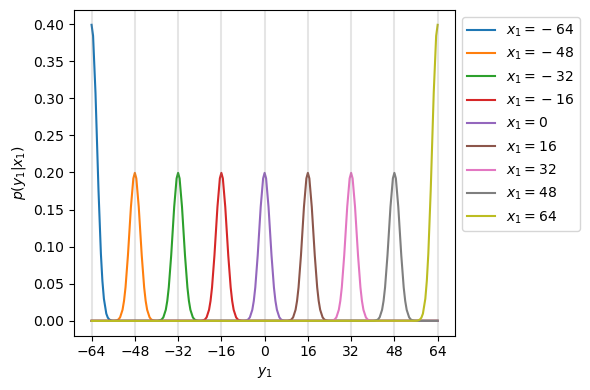

In [74]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6,4))

for x1=-64:16:64
    idx = find_nearest_point(x1, xref, e_norm, interpo_xs, Np)
    p_y1_given_x1 = get_gaussian(k_delta, xref, idx)
    p_y1_given_x1 = p_y1_given_x1 ./ sum(w0 .* p_y1_given_x1)
    ax.plot(xref, p_y1_given_x1, label=@sprintf "\$x_1=%d\$" x1)
    ax.axvline(x1, color="grey", alpha=0.2)
end
ax.set_xticks(-64:16:64)
ax.legend(bbox_to_anchor=(1,1))
ax.set_ylabel("\$p(y_1|x_1)\$")
ax.set_xlabel("\$y_1\$")

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/emission_x_example.svg")
plt.show()

### Part 6-2: Setup $p(y_1|x_1)$ matrix

In [8]:
p_y_given_x_mat = get_p_y_given_x_mat(N, k_delta, xref, w0);

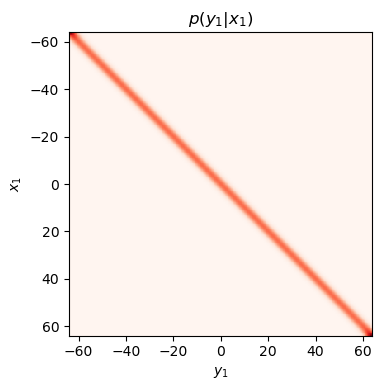

In [10]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6,4))

im = ax.imshow(p_y_given_x_mat, cmap="Reds", extent=(-64,64,64,-64))
ax.set_xlabel("\$y_1\$")
ax.set_ylabel("\$x_1\$")
title = "\$p(y_1|x_1)\$"
ax.set_title(title)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/p_y1_given_x1_mat.pdf")
plt.show()

### Part 7: get $p(x_1)$ and $p(x_1,y_1)$ and $p(x_1|y_1)$

In [13]:
p_x1 = zeros(N,1)
p_x1[:,1] = p_eq;

In [14]:
p_x1_y1_mat = zeros(N,N)
for col_idx=1:N
    p_x1_y1_mat[:,col_idx] = p_x1 .* p_y_given_x_mat[:,col_idx]
end

$p(x_1|y_1) = \frac{p(x_1,y_1)}{p(y_1)}$

In [15]:
idx = find_nearest_point(y_record[1], xref, e_norm, interpo_xs, Np)
p_x1_given_y1 = p_x1_y1_mat[:,idx] / sum(w0 .* p_x1_y1_mat[:,idx]);

$p(y_1)=\int p(x_1,y_1)dx_1$

In [16]:
p_y1 = zeros(N,1)
for idx=1:N
    p_y1[idx] = sum(w0 .* p_x1_y1_mat[:,idx])
end
sum(w0 .* p_y1)

1.0000000000000004

$p(x_1)=\int p(x_1,y_1)dy_1$

In [17]:
p_x1_from_joint = zeros(N,1)
for idx=1:N
    p_x1_from_joint[idx] = sum(w0 .* p_x1_y1_mat[idx,:])
end
sum(w0 .* p_x1_from_joint)

1.0000000000000004

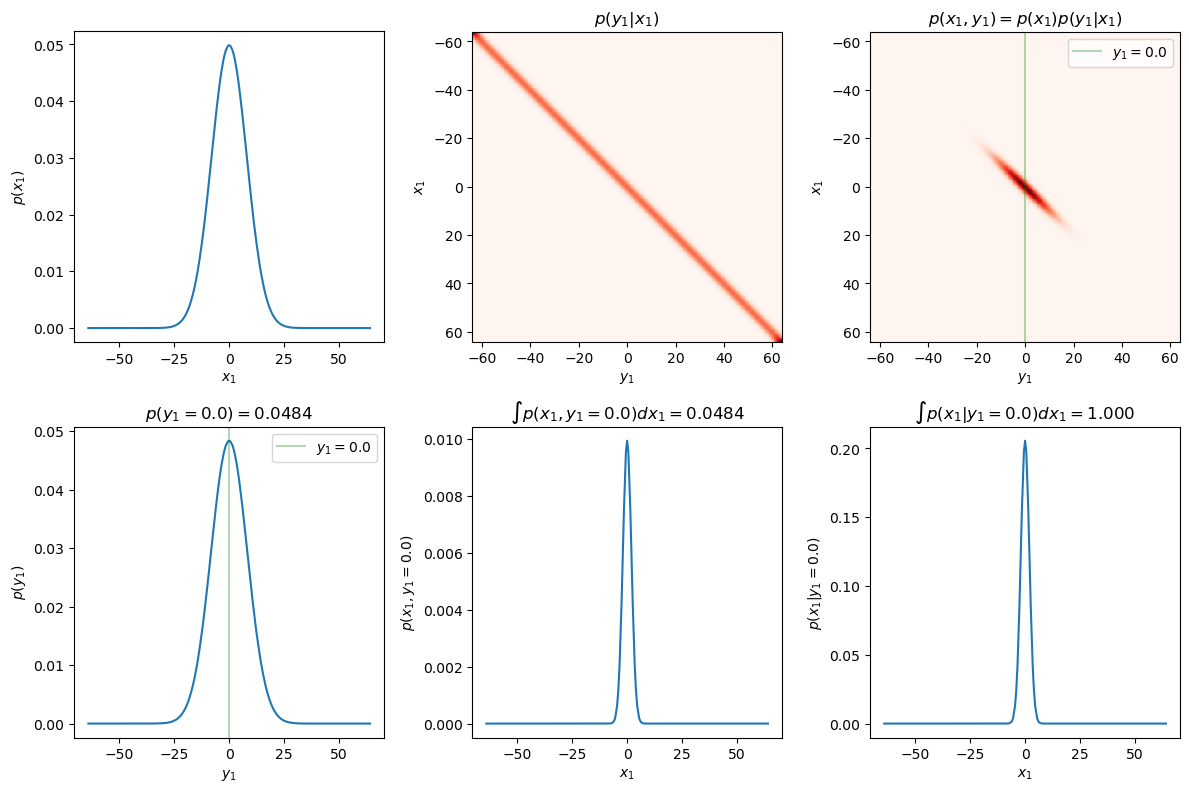

In [75]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12,8))

ax = axes[1,1]
ax.plot(xref, p_x1, label="\$p(x_1)\$")
ax.set_xlabel("\$x_1\$")
ax.set_ylabel("\$p(x_1)\$")

ax = axes[1,2]
im = ax.imshow(p_y_given_x_mat, cmap="Reds", extent=(-64,64,64,-64))
ax.set_xlabel("\$y_1\$")
ax.set_ylabel("\$x_1\$")
title = "\$p(y_1|x_1)\$"
ax.set_title(title)

ax = axes[1,3]
im = ax.imshow(p_x1_y1_mat, cmap="Reds", extent=(-64,64,64,-64))
ax.set_xlabel("\$y_1\$")
ax.set_ylabel("\$x_1\$")
title = "\$p(x_1,y_1)=p(x_1)p(y_1|x_1)\$"
ax.set_title(title)
label = @sprintf "\$y_1=%.1f\$" y_record[1]
ax.axvline(y_record[1], color="green", label=label, alpha=0.3)
ax.legend()

ax = axes[2,1]
ax.plot(xref, p_y1)
ax.set_ylabel("\$p(y_1)\$")
ax.set_xlabel("\$y_1\$")
idx = find_nearest_point(y_record[1], xref, e_norm, interpo_xs, Np)
label = @sprintf "\$y_1=%.1f\$" y_record[1]
ax.axvline(y_record[1], color="green", label=label, alpha=0.3)
ax.legend()
title = @sprintf "\$p(y_1=%.1f)=%.4f\$" y_record[1] p_y1[idx]
ax.set_title(title)

ax = axes[2,2]
ax.plot(xref, p_x1_y1_mat[:,idx])
ax.set_xlabel("\$x_1\$")
ax.set_ylabel(@sprintf "\$p(x_1,y_1=%.1f)\$" y_record[1])
title = @sprintf "\$\\int p(x_1,y_1=%.1f) dx_1 = %.4f \$" y_record[1] sum(w0 .* p_x1_y1_mat[:,idx])
ax.set_title(title)

ax = axes[2,3]
ax.plot(xref, p_x1_given_y1)
ax.set_xlabel("\$x_1\$")
ax.set_ylabel(@sprintf "\$p(x_1|y_1=%.1f)\$" y_record[1])
title = @sprintf "\$ \\int p(x_1|y_1=%.1f) dx_1 = %.3f \$" y_record[1] sum(w0 .* p_x1_given_y1)
ax.set_title(title)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/single_photon_x_2.pdf")
plt.show()

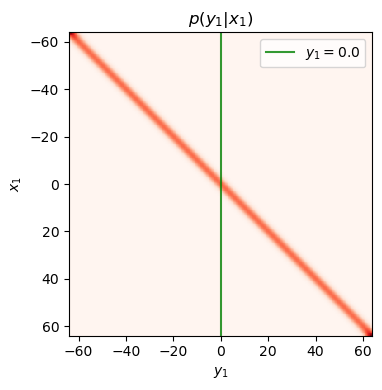

In [81]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4,4))

im = ax.imshow(p_y_given_x_mat, cmap="Reds", extent=(-64,64,64,-64))
ax.set_xlabel("\$y_1\$")
ax.set_ylabel("\$x_1\$")
title = "\$p(y_1|x_1)\$"
ax.set_title(title)
label = @sprintf "\$y_1=%.1f\$" y_record[1]
ax.axvline(y_record[1], color="green", label=label, alpha=0.8)
ax.legend()

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/emission_prob.svg")
plt.show()

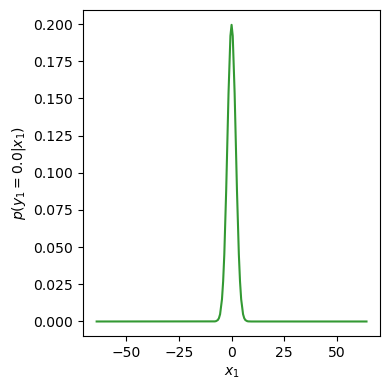

In [124]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4,4))

ax.plot(xref, p_y_given_x_mat[:,idx], color="green", alpha=0.8)
ax.set_xlabel("\$x_1\$")
ax.set_ylabel(@sprintf "\$p(y_1=%.1f|x_1)\$" y_record[1])

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/p_x1_y1_0.svg")
plt.show()

In [123]:
sum(w0 .* p_y_given_x_mat[:,idx])

1.0000000002507548

### Part 8: Build Photon Matrix

In [9]:
photon_matrix = get_photon_matrix_gaussian_v1(Nv, w0, p_y_given_x_mat, eigenvect_mat_prime, y_record[1], xref, e_norm, interpo_xs, Np);

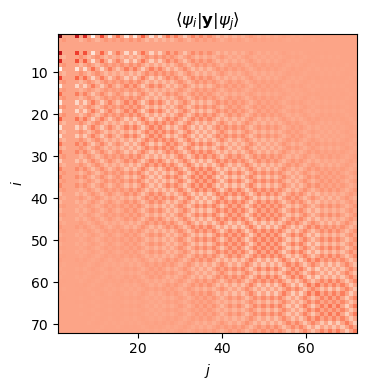

In [10]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4,4))

im = ax.imshow(photon_matrix, cmap="Reds", extent=(1,72,72,1))
ax.set_xlabel("\$j\$")
ax.set_ylabel("\$i\$")
title = "\$\\left< \\psi_i |\\mathbf{y}|\\psi_j \\right>\$"
ax.set_title(title)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/photon_mat.svg")
plt.show()

### Part 7: $\left<\rho_1\right|$

In [18]:
weight_Qx = get_weight_Qx(N, Nv, w0, eigenvect_mat_prime);

In [19]:
rho_x1 = p_x1 ./ rho_eq
rho_s1 = transpose(weight_Qx) * rho_x1;

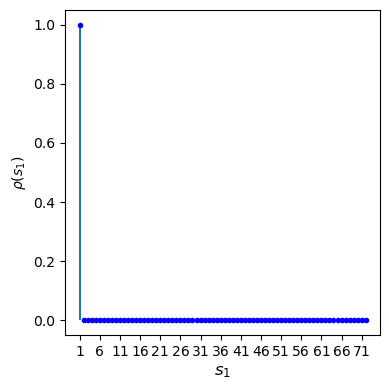

In [16]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4,4))

xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, rho_s1, "b.")
ax.vlines(xarray, ymin=0, ymax=rho_s1)
ax.set_xlabel("\$s_1\$", fontsize=12)
ax.set_ylabel("\$\\rho(s_1)\$")
ax.set_xticks(xticks)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/rho1.svg")
plt.show()

In [72]:
rho_x1_given_y1 = p_x1_given_y1 ./ rho_eq;

In [73]:
rho_s1_given_y1 = transpose(weight_Qx) * rho_x1_given_y1;

In [74]:
rho_s1_given_y1

72×1 Array{Float64,2}:
  0.9999894505580875
 -4.914399442945694e-11
  0.00010233910890021629
  0.00012582587542227686
  0.6655124836787225
 -9.066734862894776e-11
  0.5424567201371104
 -4.036694589704126e-10
 -0.4662225816570503
  4.071597170529628e-9
  0.41070588917059603
 -2.614002816980765e-8
 -0.3395209606790259
  ⋮
  0.007899392059933966
 -1.6647366596345137e-8
  0.0062243933052634065
  1.4003948875518368e-8
  0.0031493077420574923
  4.9384217687409304e-9
  0.002459352856456584
 -2.6030511079966345e-10
  0.0018230258367785343
  3.18083862027585e-9
 -0.0012461462670588508
 -3.1156288660127984e-9

### Part 8: $\left<\rho_1\right|\textbf{y}_1$

In [21]:
row_vec = zeros(1,Nv)
row_vec[1,:] = rho_s1
rho_y1 = row_vec * photon_matrix

1×72 Array{Float64,2}:
 0.0483773  -2.3766e-12  4.95094e-6  6.08718e-6  …  -6.02859e-5  -1.50715e-10

In [22]:
rho_y1

1×72 Array{Float64,2}:
 0.0483773  -2.3766e-12  4.95094e-6  6.08718e-6  …  -6.02859e-5  -1.50715e-10

### $p(x_1,y_1) = \rho_{\text{eq}}(x) \left<\rho_1|\textbf{y}_1|x\right>$

In [19]:
rho_x1_y1_from_eigenspace = eigenvect_mat_prime * rho_y1[1,:]
p_x1_y1_from_eigenspace = rho_eq .* rho_x1_y1_from_eigenspace;

### $p(x_1|y_1)$

In [20]:
rho_s1_given_y1 = rho_y1 ./ rho_y1[1]
rho_x1_given_y1_from_eigenspace = eigenvect_mat_prime * rho_s1_given_y1[1,:]
p_x1_given_y1_from_eigenspace = rho_eq .* rho_x1_given_y1_from_eigenspace;

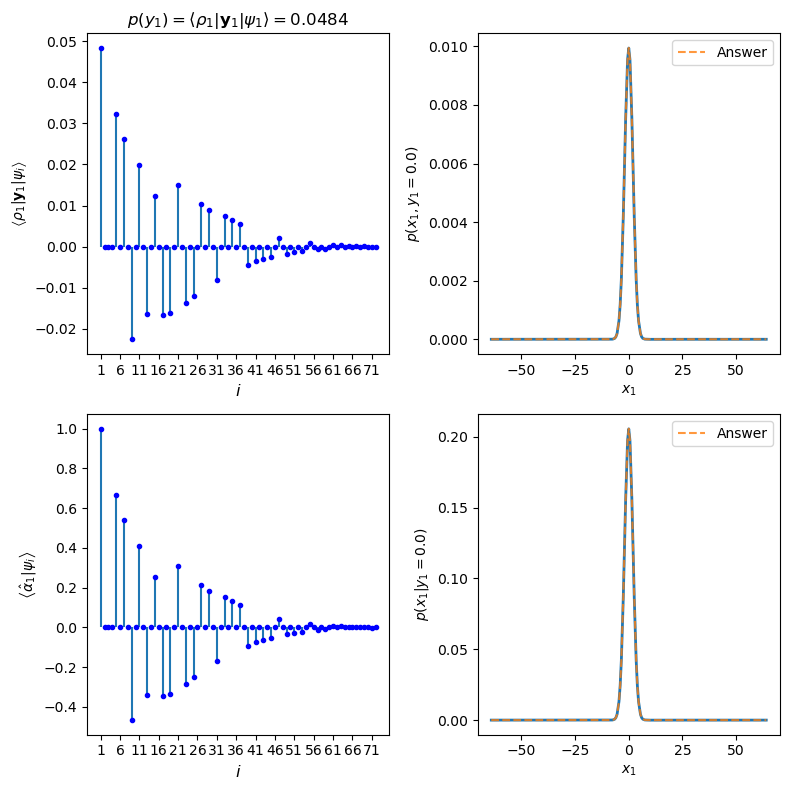

In [175]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8))

ax = axes[1,1]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, rho_y1[1,:], "b.")
ax.vlines(xarray, ymin=0, ymax=rho_y1[1,:])
ax.set_xlabel("\$i\$", fontsize=12)
ax.set_ylabel("\$\\left<\\rho_1|\\mathbf{y}_1|\\psi_i\\right>\$")
ax.set_xticks(xticks)
title = @sprintf "\$p(y_1)=\\left<\\rho_1|\\mathbf{y}_1|\\psi_1\\right>=%.4f\$" rho_y1[1]
ax.set_title(title)

ax = axes[1,2]
ax.plot(xref, p_x1_y1_from_eigenspace, linewidth=2, alpha=1)
ax.plot(xref, p_x1_y1_mat[:,idx], "--", linewidth=1.5, alpha=0.8, label="Answer")
ax.set_xlabel("\$x_1\$")
ax.set_ylabel(@sprintf "\$p(x_1,y_1=%.1f)\$" y_record[1])
ax.legend()

ax = axes[2,1]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, rho_s1_given_y1[1,:], "b.")
ax.vlines(xarray, ymin=0, ymax=rho_s1_given_y1[1,:])
ax.set_xlabel("\$i\$", fontsize=12)
ax.set_ylabel("\$\\left<\\hat{\\alpha}_1|\\psi_i\\right>\$")
ax.set_xticks(xticks)

ax = axes[2,2]
ax.plot(xref, p_x1_given_y1_from_eigenspace, linewidth=2, alpha=1)
ax.plot(xref, p_x1_given_y1, "--", linewidth=1.5, alpha=0.8, label="Answer")
ax.set_xlabel("\$x_1\$")
ax.set_ylabel(@sprintf "\$p(x_1|y_1=%.1f)\$" y_record[1])
ax.legend()

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/rho_y1.pdf")
plt.show()

### Part 9: $\left<\hat{\alpha}_1 \right| e^{-\textbf{H}\Delta t} $

In [28]:
alpha_hat_s1 = rho_s1_given_y1

1×72 Array{Float64,2}:
 1.0  -4.91264e-11  0.00010234  0.000125827  …  -0.00124616  -3.11541e-9

In [29]:
D_guess = 500
expLQDT = exp.(-(D_guess .* eigenvalues_prime) .* save_freq);
alpha_hat_s1_edt = alpha_hat_s1 .* transpose(expLQDT)

1×72 Array{Float64,2}:
 1.0  -4.54345e-11  9.23208e-5  0.000113501  …  -3.51499e-10  -5.77636e-16

### $\rho(x_2|x_1,y_1) = \left<\hat{\alpha}_1 | e^{-\textbf{H}\Delta t} | x \right>$

In [37]:
rho_x2_given_x1_y1 = eigenvect_mat_prime * alpha_hat_s1_edt[1,:]
p_x2_given_x1_y1 = rho_eq .* rho_x2_given_x1_y1;
sum(w0 .* p_x2_given_x1_y1)

0.9999894505584017

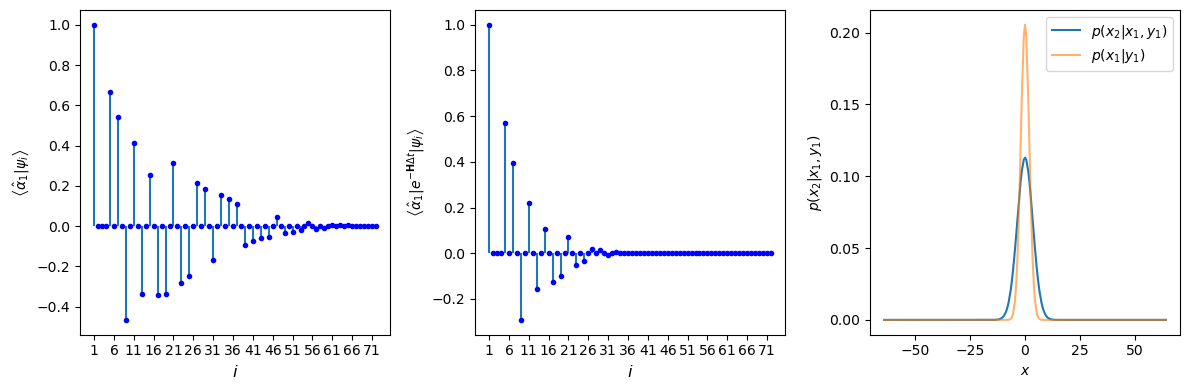

In [38]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

ax = axes[1]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, alpha_hat_s1[1,:], "b.")
ax.vlines(xarray, ymin=0, ymax=alpha_hat_s1[1,:])
ax.set_xlabel("\$i\$", fontsize=12)
ax.set_ylabel("\$\\left<\\hat{\\alpha}_1|\\psi_i\\right>\$")
ax.set_xticks(xticks)

ax = axes[2]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, alpha_hat_s1_edt[1,:], "b.")
ax.vlines(xarray, ymin=0, ymax=alpha_hat_s1_edt[1,:])
ax.set_xlabel("\$i\$", fontsize=12)
ax.set_ylabel("\$\\left<\\hat{\\alpha}_1|e^{-\\mathbf{H}\\Delta t}|\\psi_i\\right>\$")
ax.set_xticks(xticks)

ax = axes[3]
ax.plot(xref, p_x2_given_x1_y1, label="\$p(x_2|x_1,y_1)\$")
ax.plot(xref, p_x1_given_y1_from_eigenspace, label="\$p(x_1|y_1)\$", alpha=0.6)
ax.set_xlabel("\$x\$")
ax.set_ylabel("\$p(x_2|x_1,y_1)\$")
ax.legend()

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/alpha_hat_s1_edt.pdf")
plt.show()